In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats

%matplotlib inline

In [2]:
# Path to zip files
path = r"C:\Users\lewisd4\Loneliness\Raw_Data\\"

In [3]:
data = pd.read_csv(path[:-10] + "final_data.csv", index_col = 0)

# Convert to GeoDataFrame

In [4]:
geo_data = gpd.GeoDataFrame(data = data, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = data.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

,pcstrip,Year,NUMBER_OF_PATIENTS,SHA,PCT,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,...,blood pressure_zscore,hypertension_zscore,diabetes_zscore,cardiovascular disease_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,loneliness_zscore,loneills,geometry
0,AL100BS,2016,3171.916667,Q58,06K,522443.0,208996.0,E01023927,E02004990,C1,...,0.281695,-0.311210,-0.457039,-0.403666,-0.470144,-0.088685,-0.206785,-0.696324,-2.090846,POINT (522443 208996)
1,AL100BS,2017,7990.750000,Q58,06K,522443.0,208996.0,E01023927,E02004990,C1,...,0.467674,-0.262544,-0.275512,-0.192223,-0.434156,-0.086022,0.199294,-0.315757,-0.894752,POINT (522443 208996)
2,AL100BS,2018,9624.416667,Q58,06K,522443.0,208996.0,E01023927,E02004990,C1,...,0.709112,-0.041739,0.129947,0.097690,-0.526029,-0.088685,0.937151,0.328936,0.616736,POINT (522443 208996)
3,AL100NL,2016,4195.000000,Q58,06K,522442.0,208808.0,E01023920,E02004991,C1,...,-0.046907,0.456131,-0.055416,-0.127068,-0.120109,-0.087082,0.213252,-0.086705,-0.262717,POINT (522442 208808)
4,AL100NL,2017,10554.666667,Q58,06K,522442.0,208808.0,E01023920,E02004991,C1,...,-0.103745,0.397698,0.041207,-0.093135,0.088218,-0.088685,0.361831,0.026190,0.541874,POINT (522442 208808)


C:\Python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


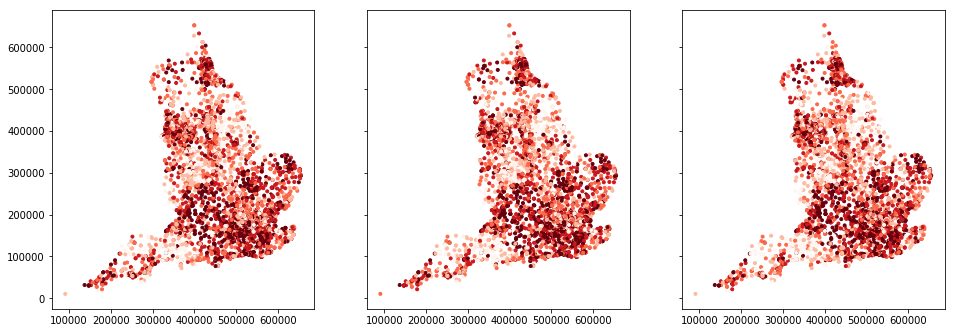

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6), sharex = True, sharey = True)

geo_data[geo_data['Year'] == 2016].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax1);
geo_data[geo_data['Year'] == 2017].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax2);
geo_data[geo_data['Year'] == 2018].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax3);

## k-nearest neighbour interpolation

Non-parametric interpolation of loneliness based on local set of _k_ nearest neighbours for each cell in our evaluation grid.

Effectively becomes an inverse distance weighted (idw) interpolation when weights are set to be distance based.

In [6]:
def idw_model(k, p):
    def _inv_distance_index(weights, index=p):
        return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
    return KNeighborsRegressor(k, weights=_inv_distance_index)

def grid(xmin, xmax, ymin, ymax, cellsize):
    # Set x and y ranges to accommodate cellsize
    xmin = (xmin // cellsize) * cellsize
    xmax = -(-xmax // cellsize) * cellsize # ceiling division
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    # Make meshgrid
    x = np.linspace(xmin,xmax,(xmax-xmin)/cellsize)
    y = np.linspace(ymin,ymax,(ymax-ymin)/cellsize)
    return np.meshgrid(x,y)

def reshape_grid(xx,yy):
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

def reshape_image(z, xx):
    return np.flip(z.reshape(np.shape(xx)),0)

def idw_surface(locations, values, xmin, xmax, ymin, ymax, cellsize, k=5, p=2):
    # Make and fit the idw model
    idw = idw_model(k,p).fit(locations, values)
    # Make the grid to estimate over
    xx, yy = grid(xmin, xmax, ymin, ymax, cellsize)
    # reshape the grid for estimation
    xy = reshape_grid(xx,yy)
    # Predict the grid values
    z = idw.predict(xy)
    # reshape to image array
    z = reshape_image(z, xx)
    return z

## 2016 data

In [7]:
# Get point locations and values from data
points = geo_data[geo_data['Year'] == 2016][['oseast1m','osnrth1m']].values
vals = geo_data[geo_data['Year'] == 2016]['loneills'].values

surface2016 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

C:\Python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


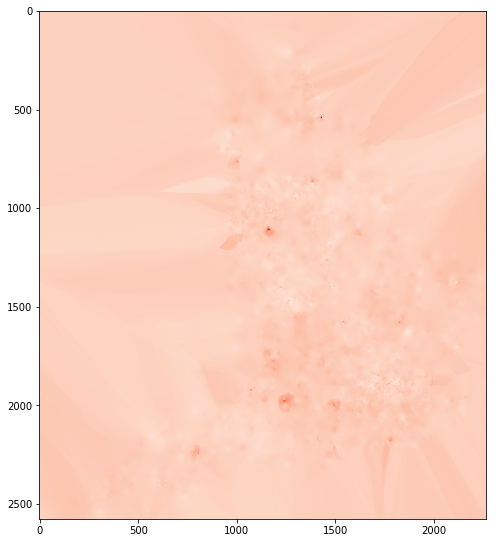

In [8]:
# Look at surface
f, ax = plt.subplots(figsize = (8,10))
ax.imshow(surface2016, cmap='Reds')
ax.set_aspect('equal')

## 2017 Data

In [9]:
# Get point locations and values from data
points = geo_data[geo_data['Year'] == 2017][['oseast1m','osnrth1m']].values
vals = geo_data[geo_data['Year'] == 2017]['loneills'].values

surface2017 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

C:\Python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


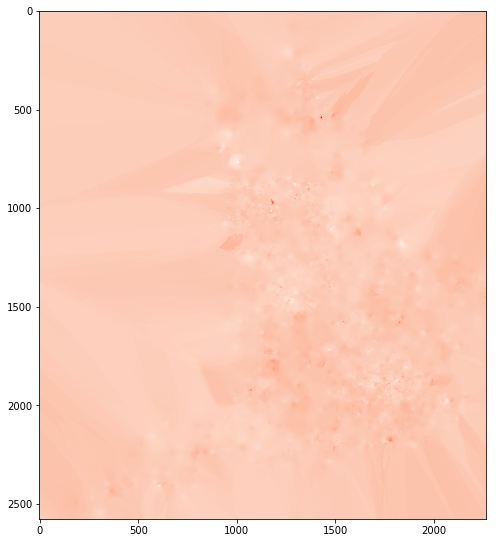

In [10]:
# Look at surface
f, ax = plt.subplots(figsize = (8,10))
ax.imshow(surface2017, cmap='Reds')
ax.set_aspect('equal')

## 2018 Data

In [11]:
# Get point locations and values from data
points = geo_data[geo_data['Year'] == 2018][['oseast1m','osnrth1m']].values
vals = geo_data[geo_data['Year'] == 2018]['loneills'].values

surface2018 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

C:\Python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


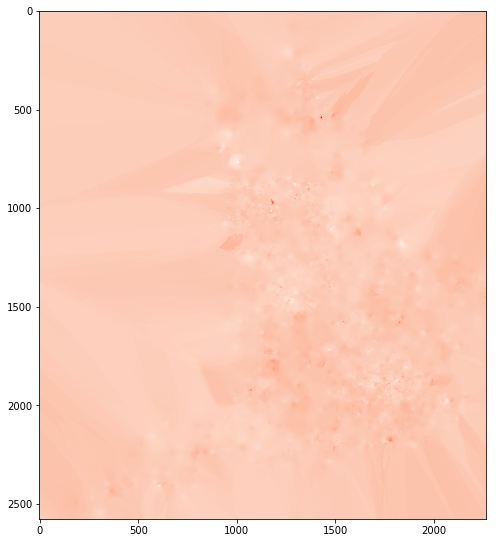

In [12]:
# Look at surface
f, ax = plt.subplots(figsize = (8,10))
ax.imshow(surface2017, cmap='Reds')
ax.set_aspect('equal')

# Extract Values to MSOAs

Get 2011 MSOAs from the Open Geography Portal: http://geoportal.statistics.gov.uk/

In [13]:
# Get MSOAs which we use to aggregate the loneills variable.
filestring = './Data/MSOAs/Middle_Layer_Super_Output_Areas_December_2011_Full_Clipped_Boundaries_in_England_and_Wales.shp'

msoas = gpd.read_file(filestring)
msoas.to_crs({'init':'epsg:27700'})
# drop the Wales MSOAs
msoas = msoas[msoas['msoa11cd'].str[:1] == 'E'].copy()

In [44]:
# Get GB countries data to use for representation
gb = gpd.read_file('./Data/GB/Countries_December_2017_Generalised_Clipped_Boundaries_in_UK_WGS84.shp')
gb = gb.to_crs({'init':'epsg:27700'})
# get England
eng = gb[gb['ctry17nm'] == 'England'].copy()

In [14]:
# Make affine transform for raster
trans = rst.Affine.from_gdal(90000-125,250,0,654000+125,0,-250)

In [17]:
# NB This process is slooow - write bespoke method?
# 2016
msoa_zones = zonal_stats(msoas['geometry'], surface2016, affine = trans, stats = 'mean', nodata = np.nan)
msoas['loneills_2016'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2017
msoa_zones = zonal_stats(msoas['geometry'], surface2017, affine = trans, stats = 'mean', nodata = np.nan)
msoas['loneills_2017'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2018
msoa_zones = zonal_stats(msoas['geometry'], surface2018, affine = trans, stats = 'mean', nodata = np.nan)
msoas['loneills_2018'] = list(map(lambda x: x['mean'] , msoa_zones))

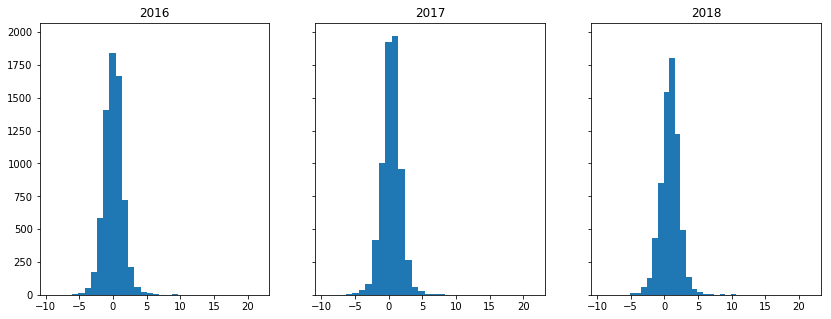

In [26]:
# Check out the distributions of loneills by MSOA
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(14,5), sharex = True, sharey=True)

ax1.hist(msoas['loneills_2016'], bins = 30)
ax2.hist(msoas['loneills_2017'], bins = 30)
ax3.hist(msoas['loneills_2018'], bins = 30)

ax1.set_title("2016")
ax2.set_title("2017")
ax3.set_title("2018");

In [ ]:
-10 -> -5;-5 -> -3; -3 -> -2 ; -2 -> -1;-1 -> 1; 1 -> 2; 2 -> 3; 3 -> 5; 5-> 10; 10-> 22

In [42]:
bins = [-10, -5, -3, -2, -1, 1, 2, 3, 5, 10, 22]
labels = ['#01665e','#35978f', '#80cdc1','#c7eae5','#f5f5f5','#f6e8c3','#dfc27d','#bf812d','#8c510a','#543005']

msoas['loneills_2016_class'] = pd.cut(msoas['loneills_2016'], bins, labels = labels)
msoas['loneills_2017_class'] = pd.cut(msoas['loneills_2017'], bins, labels = labels)
msoas['loneills_2018_class'] = pd.cut(msoas['loneills_2018'], bins, labels = labels)

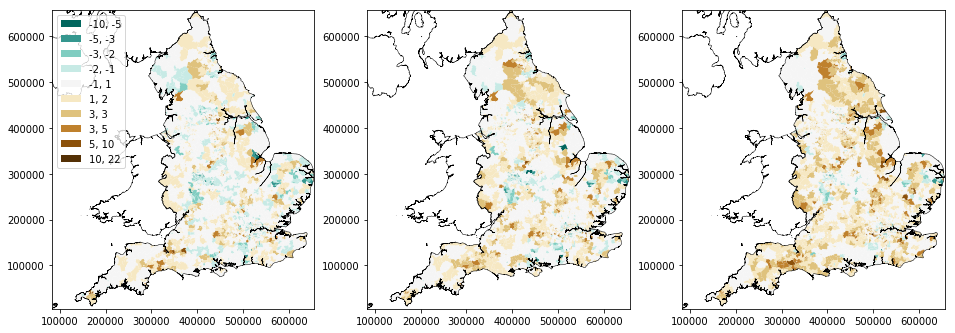

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,10))

msoas.plot(color = msoas['loneills_2016_class'], ax=ax1)
msoas.plot(color = msoas['loneills_2017_class'], ax=ax2)
msoas.plot(color = msoas['loneills_2018_class'], ax=ax3)

gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax1)
gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax2)
gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax3)

# restrict to England
ax1.set_xlim([82672,656000])
ax1.set_ylim([5342,658000])
ax2.set_xlim([82672,656000])
ax2.set_ylim([5342,658000])
ax3.set_xlim([82672,656000])
ax3.set_ylim([5342,658000])

# Make a legend
# make bespoke legend
from matplotlib.patches import Patch
handles = []
ranges = ["-10, -5","-5, -3","-3, -2","-2, -1","-1, 1","1, 2","3, 3","3, 5","5, 10","10, 22"]
for color, label in zip(labels,ranges):
    handles.append(Patch(facecolor = color, label = label))

ax1.legend(handles = handles, loc = 2);

In [49]:
# Save out msoa data as shapefile
msoas.to_file(path[:-10] + "msoa_loneliness.shp")

In [ ]:
# save out msoa data as csv
msoas.to_csv(path[:-10] + "msoa_loneliness.csv")